In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimization
from scipy.optimize import least_squares
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [2]:
df1 = pd.read_csv('df_ant1_30.csv') # in each channel we have 96 data points per antenna
df2 = pd.read_csv('df_ant2_30.csv')
df3 = pd.read_csv('df_ant3_30.csv')

In [3]:
t = df1[df1.Channel >= 11]
t['omega'] = (t['Channel']-11)*2+ 2428.25
tless = df1[df1.Channel < 11]
tless['omega'] = (tless['Channel'])*2 + 2404.25
df1 = t.append(tless)

<ipython-input-3-3d26178556e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['omega'] = (t['Channel']-11)*2+ 2428.25
<ipython-input-3-3d26178556e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tless['omega'] = (tless['Channel'])*2 + 2404.25


In [4]:
X12 = (df1['I'] + 1j*df1['Q']) * (df2['I'] - 1j*df2['Q'])
X23 = (df2['I'] + 1j*df2['Q']) * (df3['I'] - 1j*df3['Q'])
X13 = (df1['I'] + 1j*df1['Q']) * (df3['I'] - 1j*df3['Q'])

In [5]:
d = {'channel': df1['Channel'],'omega':df1['omega'],'x12': X12, 'x23': X23, 'x13': X13, 'idx1':df1['sample_idx'], 'idx2':df2['sample_idx'], 'idx3':df3['sample_idx']}
data = pd.DataFrame(data=d)
data['phi12'] = np.angle(X12)* 180/(2*np.pi)
data['phi23'] = np.angle(X23)* 180/(2*np.pi)
data['phi13'] = np.angle(X13)* 180/(2*np.pi)
# data.to_csv('phi_30degree.csv', index = False)

#### Another kalman filter
Here the Q and R is changing for each part. in the loop! 
This is not necessary, beacuse after a while, this will stay the same. So, not required. Haha!!

In [22]:
sdata = data

In [23]:
x_observations = sdata['phi13'][96:96*2]
v_observations = sdata['omega'][96:96*2]
t = 2.5e-8
z = np.c_[x_observations, v_observations]
def prediction2d(x, v, t):
    A = np.array([[1, t],
                  [0, 1]])
    X = np.array([[x],
                  [v]])
    X_prime = A.dot(X) 
    return X_prime

In [24]:
error_obs_x = sdata['phi13'].std()
error_obs_v = sdata['omega'].std()
error_est_x = 20;
error_est_v = 5;

In [25]:
def covariance2d(sigma1, sigma2):
    cov1_2 = sigma1 * sigma2
    cov2_1 = sigma2 * sigma1
    cov_matrix = np.array([[sigma1 ** 2, cov1_2],
                           [cov2_1, sigma2 ** 2]])
    return np.diag(np.diag(cov_matrix))


# Initial Estimation Covariance Matrix
P = covariance2d(error_est_x, error_est_v)
A = np.array([[1, t],
              [0, 1]])
v = 2404
# Initial State Matrix
X = np.array([[z[0][0]],
              [v]])
n = len(z[0])

In [26]:
from numpy.linalg import inv

In [27]:
for data in z[1:]:
    X = prediction2d(X[0][0], X[1][0], t)
    # To simplify the problem, professor
    # set off-diagonal terms to 0.
    P = np.diag(np.diag(A.dot(P).dot(A.T)))

    # Calculating the Kalman Gain
    H = np.identity(n)
    R = covariance2d(error_obs_x, error_obs_v)
    S = H.dot(P).dot(H.T) + R
    K = P.dot(H).dot(inv(S))

    # Reshape the new data into the measurement space.
    Y = H.dot(data).reshape(n, -1)

    # Update the State Matrix
    # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
    X = X + K.dot(Y - H.dot(X))

    # Update Process Covariance Matrix
    P = (np.identity(len(K)) - K.dot(H)).dot(P)

print("Kalman Filter State Matrix:\n", X)

Kalman Filter State Matrix:
 [[ -75.2164035 ]
 [2457.30184141]]


## The pakage inv is wierd
dont run unless u are defenetly required! 
yet the above kalman filter, functions better

In [6]:
f = KalmanFilter (dim_x=2, dim_z=1)

In [7]:
f.x = np.array([[55],   # theta
                [2404]])  #omega
f.F = np.array([[1.,2.5e-8],
                [0.,1.]])
f.H = np.array([[1,0]])
f.P *= 1000.
f.R = np.array([[2.5]]) # dimentional

In [8]:
z12 = data['phi12']
results = []
for i in range(len(z12)):
    f.Q = Q_discrete_white_noise(dim=2, dt=2.5e-8, var=1/np.abs(data['x12'][i]))
    f.predict()
    f.update(z12[i])
    results.append(f.x)
res_arr = np.asarray(results)
data['phi12_kf'] = res_arr[:,0] 
data['omega12_kf'] = res_arr[:,1] 

In [9]:
z23 = data['phi23']
results = []
for i in range(len(z23)):
    f.Q = Q_discrete_white_noise(dim=2, dt=2.5e-8, var=1/np.abs(data['x23'][i]))
    f.predict()
    f.update(z23[i])
    results.append(f.x)
res_arr = np.asarray(results)
data['phi23_kf'] = res_arr[:,0] 
data['omega23_kf'] = res_arr[:,1] 

##### There is a problem here!!!
the average of phi13 = -63! but after applying kf, this average drops to 9.7. also the omega should be ~2400

In [10]:
z13 = data['phi13']
results = []
for i in range(len(z13)):
    f.Q = Q_discrete_white_noise(dim=2, dt=2.5e-8, var=int(data['phi13'].std()/np.abs(data['x13'][i])))
    f.predict()
    f.update(z13[i])
    results.append(f.x)
res_arr = np.asarray(results)
data['phi13_kf'] = res_arr[:,0] 
data['omega13_kf'] = res_arr[:,1] 

In [11]:
print(np.average(data['phi23']), np.average(data['phi23_kf']), np.average(data['omega23_kf']))


16.448798889914162 43.471962924867725 -2581.719447335086


In [12]:
print(np.average(data['phi12']), np.average(data['phi12_kf']), np.average(data['omega12_kf']))

55.24085644253681 58.041837828638656 2309.4607393771116


In [13]:
print( np.average(data['phi13']), np.average(data['phi13_kf']), np.average(data['omega13_kf']))

-63.00629061349498 9.78830246647539 -29439.628439544787


C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:>], dtype=object)

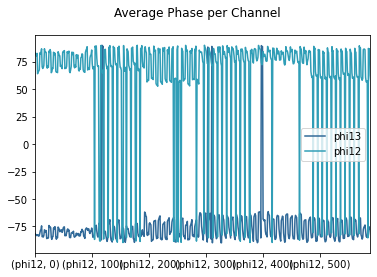

In [14]:
data.unstack(level=0)[['phi13']].plot(subplots=True, title="Average Phase per Channel", xlim=[0,588], color= '#306998', label='phi13', legend=True)
data.unstack(level=0)[['phi12']].plot(subplots=True, title="Average Phase per Channel", xlim=[0,588], color= '#309EB7', label='phi12', legend=True)


C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:>], dtype=object)

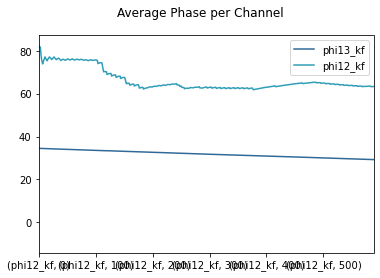

In [15]:
data.unstack(level=0)[['phi13_kf']].plot(subplots=True, title="Average Phase per Channel", xlim=[0,588], color= '#306998', label='phi13_kf', legend=True)
data.unstack(level=0)[['phi12_kf']].plot(subplots=True, title="Average Phase per Channel", xlim=[0,588], color= '#309EB7', label='phi12_kf', legend=True)


C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:>], dtype=object)

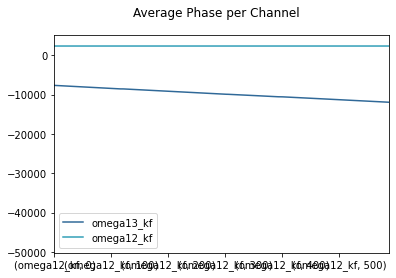

In [16]:
data.unstack(level=0)[['omega13_kf']].plot(subplots=True, title="Average Phase per Channel", xlim=[0,588], color= '#306998', label='omega13_kf', legend=True)
data.unstack(level=0)[['omega12_kf']].plot(subplots=True, title="Average Phase per Channel", xlim=[0,588], color= '#309EB7', label='omega12_kf', legend=True)


In [17]:
phi_channel = []
for i in range(0, len(data),96):
    phi_channel.append({"channel":data['channel'][i], 
                       "omega":data['omega'][i], 
                       "ave_phi12": np.average(data['phi12'][i:i+96]),
                       "ave_phi23": np.average(data['phi23'][i:i+96]), 
                       "ave_phi13": np.average(data['phi13'][i:i+96]),
                       "omega12": np.average(data['omega12_kf'][i:i+96]),
                       "omega23": np.average(data['omega23_kf'][i:i+96]),
                       "omega13": np.average(data['omega13_kf'][i:i+96]),
                       "phi12_kf": np.average(data['phi12_kf'][i:i+96]),
                       "phi23_kf": np.average(data['phi23_kf'][i:i+96]),
                       "phi13_kf": np.average(data['phi13_kf'][i:i+96]),})
saverage_phi_perchannel = pd.DataFrame(phi_channel)

In [18]:
saverage_phi_perchannel['theta12_kf'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['phi12_kf'])
saverage_phi_perchannel['theta23_kf'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['phi23_kf'])
saverage_phi_perchannel['theta13_kf'] = ((2.9*1e10)/(2*3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['phi13_kf'])
saverage_phi_perchannel['theta12'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['ave_phi12']) # c/f * xx * 1/2pi * 1/d
saverage_phi_perchannel['theta23'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['ave_phi23'])
saverage_phi_perchannel['theta13'] = ((2.9*1e10)/(2*3.5*2*np.pi)*(1/saverage_phi_perchannel['omega'])*10**-6*saverage_phi_perchannel['ave_phi13'])

In [19]:
print('\n theta (12, 23, 13)', np.average(saverage_phi_perchannel['theta12']), np.average(saverage_phi_perchannel['theta23']), np.average(saverage_phi_perchannel['theta13']),
      '\n theta_KF', np.average(saverage_phi_perchannel['theta12_kf']), np.average(saverage_phi_perchannel['theta23_kf']), np.average(saverage_phi_perchannel['theta13_kf']))   


 theta (12, 23, 13) 29.844480165084693 8.866094094214848 -17.00982422432494 
 theta_KF 31.349618924463208 23.480214630707962 2.6420782611759885


In [20]:
saverage_phi_perchannel

,channel,omega,ave_phi12,ave_phi23,ave_phi13,omega12,omega23,omega13,phi12_kf,phi23_kf,phi13_kf,theta12_kf,theta23_kf,theta13_kf,theta12,theta23,theta13
0,33,2472.25,75.653014,23.536170,-80.810817,2403.996300,2050.626753,-7980.368743,76.356493,55.205796,34.025622,40.728993,29.447090,9.074731,40.353753,12.554328,-21.552477
1,31,2468.25,49.969694,19.452901,-74.952405,2403.359260,1936.552039,-8690.897437,67.832755,54.757060,33.141634,36.241019,29.255064,8.853293,26.697318,10.393105,-20.022418
2,26,2458.25,62.459766,30.975733,-77.189501,2402.885464,1835.259876,-9406.922409,63.519286,54.368061,32.257530,34.074512,29.165396,8.652172,33.506139,16.616733,-20.703905
3,8,2420.25,60.839003,21.797177,-71.113819,2402.557791,1737.606862,-10093.576496,62.703233,54.003430,31.414649,34.164871,29.424643,8.558390,33.149116,11.876545,-19.373758
4,7,2418.25,77.362222,23.266263,-69.996515,2403.738464,1625.920985,-10755.404104,63.999565,53.595053,30.607048,34.900039,29.226283,8.345269,42.186921,12.687484,-19.085138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,17,2440.25,5.381722,-10.011309,-23.379588,2415.263323,-6956.022168,-46157.526693,56.729171,35.388541,-8.082702,30.656474,19.123986,-2.183948,2.908285,-5.410117,-6.317171
70,35,2476.25,75.449462,23.891746,-80.658791,2354.939233,-7137.694504,-46518.298031,56.456204,35.139133,-8.484186,30.065419,18.713139,-2.259102,40.180168,12.723409,-21.477183
71,16,2438.25,10.842352,5.999205,-26.283444,2318.496168,-7264.451138,-46867.095206,56.305075,34.961879,-8.876580,30.452250,18.908916,-2.400421,5.864019,3.244633,-7.107619
72,34,2474.25,65.873872,23.017604,-79.858524,2254.550240,-7394.476402,-47269.724860,56.032097,34.781301,-9.311505,29.863684,18.537550,-2.481398,35.109100,12.267798,-21.281282
